In [ ]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [66]:
def parse_number(x):
    """
    Convert strings like '1.912.990' or '0,4' to float.
    Works with NaNs and already-numeric values.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s == '' or s == '*':
        return np.nan
    # remove thousand separators, convert decimal comma to dot
    s = s.replace('.', '').replace(',', '.')
    try:
        return float(s)
    except ValueError:
        return np.nan


In [67]:
bls_records = []

xlsx_files = sorted(glob.glob("Graphic_Designer_data/*.xlsx"))

for f in xlsx_files:
    # Extract 2-digit year from filename oesm15st.xlsx → 2015
    base = os.path.basename(f)
    yy = int(base[4:6])
    year = 2000 + yy

    df = pd.read_excel(f, dtype=str)  # read everything as string so we can clean

    # Normalize column names to lowercase for robust selection
    df.columns = [c.lower() for c in df.columns]

    # We expect occ_code, tot_emp, a_median
    if not {'occ_code', 'tot_emp', 'a_mean', 'a_median'}.issubset(set(df.columns)):
        print(f"Warning: unexpected columns in {base}")

    # Filter for graphic designers
    gd = df[df['occ_code'] == '27-1024'].copy()

    if gd.empty:
        print(f"No graphic designer rows found in {base}")
        continue

    # Convert employment and salary columns
    gd['tot_emp_num'] = gd['tot_emp'].apply(parse_number)
    # A_MEDIAN is the "Median annual wage"; A_MEAN is mean annual wage
    # You can choose either; here we use median
    gd['a_median_num'] = gd['a_median'].apply(parse_number)

    total_emp = gd['tot_emp_num'].sum()
    mean_wage = gd['a_median_num'].mean()  # simple mean across states

    bls_records.append({
        "Year": year,
        "Employment": total_emp,
        "Median_Wage": mean_wage
    })

bls_df = pd.DataFrame(bls_records).sort_values("Year").reset_index(drop=True)
bls_df


,Year,Employment,Median_Wage
0,2015,205890.0,43400.188679
1,2016,212110.0,44008.113208
2,2017,211330.0,44803.962264
3,2018,219070.0,46347.358491
4,2019,216990.0,47972.830189
5,2020,202290.0,49450.188679
6,2021,205050.0,49571.132075
7,2022,213050.0,52632.452830
8,2023,214060.0,53456.981132
9,2024,215560.0,56105.849057


In [68]:
print(bls_df.info())
bls_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         10 non-null     int64  
 1   Employment   10 non-null     float64
 2   Median_Wage  10 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 372.0 bytes
None


,Year,Employment,Median_Wage
0,2015,205890.0,43400.188679
1,2016,212110.0,44008.113208
2,2017,211330.0,44803.962264
3,2018,219070.0,46347.358491
4,2019,216990.0,47972.830189
5,2020,202290.0,49450.188679
6,2021,205050.0,49571.132075
7,2022,213050.0,52632.452830
8,2023,214060.0,53456.981132
9,2024,215560.0,56105.849057


In [69]:
ai_records = []

csv_files = glob.glob("AI_data/*.csv")

for file in csv_files:
    print("Processing:", file)

    # Skip the first 2 lines (metadata + blank line)
    df = pd.read_csv(file, skiprows=2, encoding="latin1")

    # First column is Ay (YYYY-MM), second is trend
    date_col = df.columns[0]
    trend_col = df.columns[1]

    # Keep only YYYY-MM rows
    df = df[df[date_col].astype(str).str.match(r"^\d{4}-\d{2}$", na=False)].copy()

    # Extract year
    df["year"] = df[date_col].str.slice(0, 4).astype(int)

    # Convert trend to numeric
    df["trend"] = pd.to_numeric(df[trend_col], errors="coerce")

    # Yearly average popularity
    yearly = df.groupby("year")["trend"].mean().reset_index()
    yearly["tool"] = file.replace("AI_data/", "").replace(".csv", "")

    ai_records.append(yearly)

ai_df = pd.concat(ai_records, ignore_index=True)
ai_df


Processing: AI_data\ai_art.csv
Processing: AI_data\canva_ai.csv
Processing: AI_data\chatgpt.csv
Processing: AI_data\dalle.csv


,year,trend,tool
0,2015,1.916667,AI_data\ai_art
1,2016,1.750000,AI_data\ai_art
2,2017,1.666667,AI_data\ai_art
3,2018,1.833333,AI_data\ai_art
4,2019,1.750000,AI_data\ai_art
5,2020,2.583333,AI_data\ai_art
6,2021,2.833333,AI_data\ai_art
7,2022,25.666667,AI_data\ai_art
8,2023,59.833333,AI_data\ai_art
9,2024,57.000000,AI_data\ai_art


In [70]:
ai_index = (
    ai_df
    .groupby("year")["trend"]
    .mean()
    .reset_index()
    .rename(columns={"year": "Year", "trend": "AI_Popularity"})
    .sort_values("Year")
)

ai_index


,Year,AI_Popularity
0,2015,0.479167
1,2016,0.437500
2,2017,0.555556
3,2018,0.611111
4,2019,0.583333
5,2020,0.895833
6,2021,1.416667
7,2022,14.219697
8,2023,61.375000
9,2024,78.750000


In [71]:
merged = pd.merge(bls_df, ai_index, on="Year", how="inner").sort_values("Year")
merged.reset_index(drop=True, inplace=True)

print(merged.info())
merged


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           10 non-null     int64  
 1   Employment     10 non-null     float64
 2   Median_Wage    10 non-null     float64
 3   AI_Popularity  10 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 452.0 bytes
None


,Year,Employment,Median_Wage,AI_Popularity
0,2015,205890.0,43400.188679,0.479167
1,2016,212110.0,44008.113208,0.437500
2,2017,211330.0,44803.962264,0.555556
3,2018,219070.0,46347.358491,0.611111
4,2019,216990.0,47972.830189,0.583333
5,2020,202290.0,49450.188679,0.895833
6,2021,205050.0,49571.132075,1.416667
7,2022,213050.0,52632.452830,14.219697
8,2023,214060.0,53456.981132,61.375000
9,2024,215560.0,56105.849057,78.750000


In [72]:
print("Summary statistics:\n", merged.describe())

print("\nMissing values per column:\n", merged.isna().sum())


Summary statistics:
              Year     Employment   Median_Wage  AI_Popularity
count    10.00000      10.000000     10.000000      10.000000
mean   2019.50000  211540.000000  48774.905660      15.932386
std       3.02765    5489.063875   4288.872039      29.129016
min    2015.00000  202290.000000  43400.188679       0.437500
25%    2017.25000  207250.000000  45189.811321       0.562500
50%    2019.50000  212580.000000  48711.509434       0.753472
75%    2021.75000  215185.000000  51867.122642      11.018939
max    2024.00000  219070.000000  56105.849057      78.750000

Missing values per column:
 Year             0
Employment       0
Median_Wage      0
AI_Popularity    0
dtype: int64


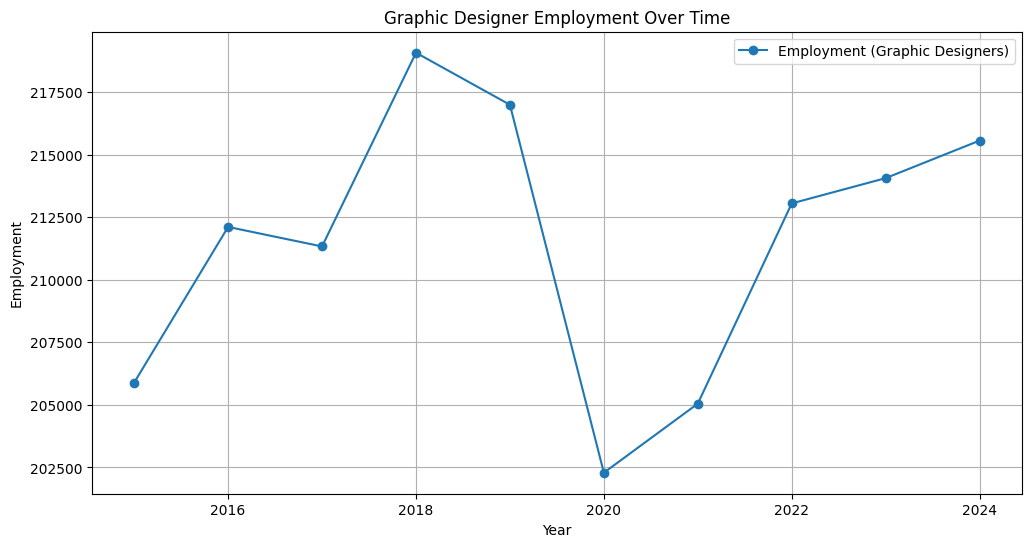

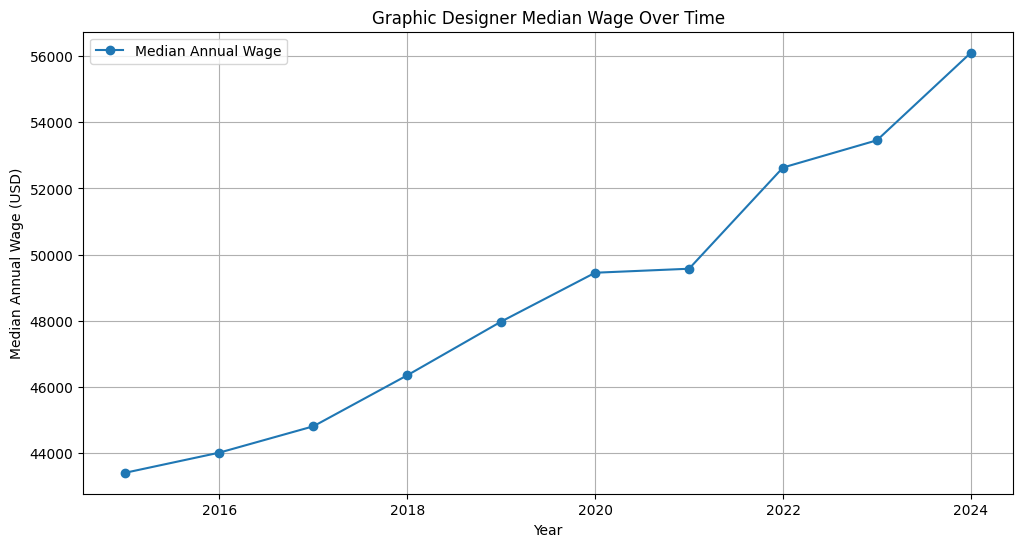

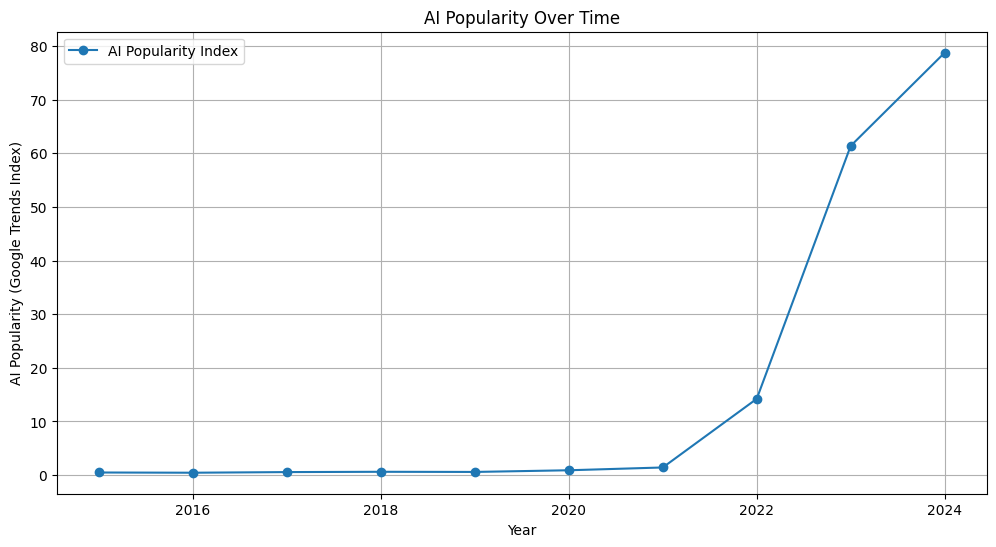

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(merged["Year"], merged["Employment"], marker='o', label="Employment (Graphic Designers)")
plt.xlabel("Year")
plt.ylabel("Employment")
plt.title("Graphic Designer Employment Over Time")
plt.grid(True)
plt.legend()
plt.savefig("plots/graph_empl_over_time.png")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(merged["Year"], merged["Median_Wage"], marker='o', label="Median Annual Wage")
plt.xlabel("Year")
plt.ylabel("Median Annual Wage (USD)")
plt.title("Graphic Designer Median Wage Over Time")
plt.grid(True)
plt.legend()
plt.savefig("plots/graph_med_wage_time.png")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(merged["Year"], merged["AI_Popularity"], marker='o', label="AI Popularity Index")
plt.xlabel("Year")
plt.ylabel("AI Popularity (Google Trends Index)")
plt.title("AI Popularity Over Time")
plt.grid(True)
plt.legend()
plt.savefig("plots/ai_popul_over_time.png")
plt.show()


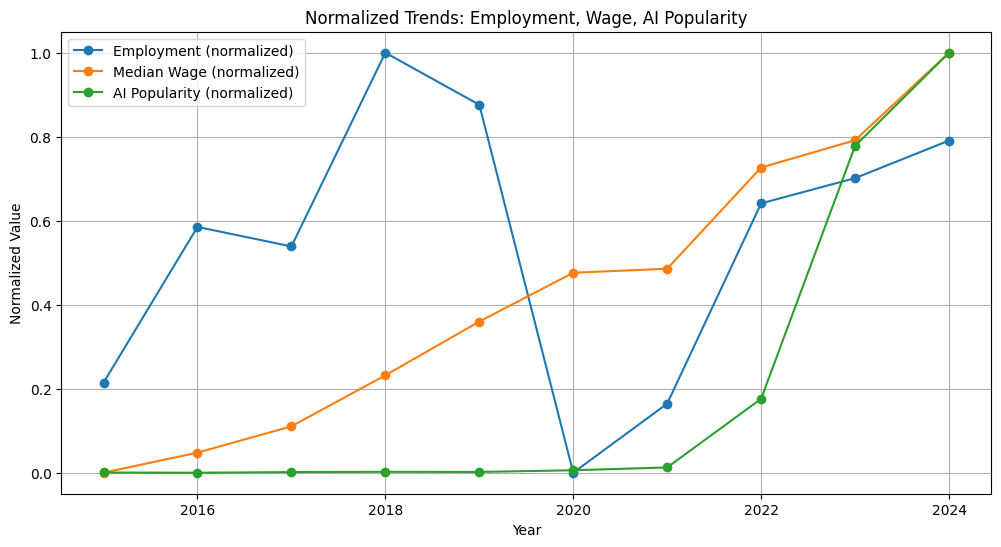

In [ ]:
norm = merged.copy()
for col in ["Employment", "Median_Wage", "AI_Popularity"]:
    norm[col + "_norm"] = (norm[col] - norm[col].min()) / (norm[col].max() - norm[col].min())

plt.figure(figsize=(12,6))
plt.plot(norm["Year"], norm["Employment_norm"], marker='o', label="Employment (normalized)")
plt.plot(norm["Year"], norm["Median_Wage_norm"], marker='o', label="Median Wage (normalized)")
plt.plot(norm["Year"], norm["AI_Popularity_norm"], marker='o', label="AI Popularity (normalized)")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.title("Normalized Trends: Employment, Wage, AI Popularity")
plt.grid(True)
plt.legend()
plt.savefig("plots/empl_wage_aipop.png")
plt.show()


In [75]:
corr_emp = merged["AI_Popularity"].corr(merged["Employment"])
corr_wage = merged["AI_Popularity"].corr(merged["Median_Wage"])

print(f"Correlation (AI Popularity vs Employment): {corr_emp:.3f}")
print(f"Correlation (AI Popularity vs Median Wage): {corr_wage:.3f}")


Correlation (AI Popularity vs Employment): 0.334
Correlation (AI Popularity vs Median Wage): 0.812


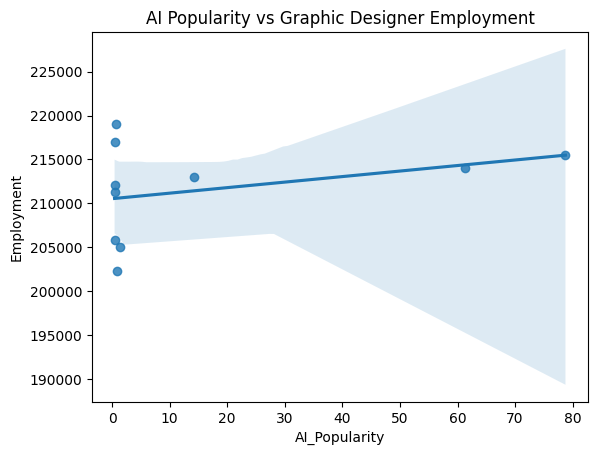

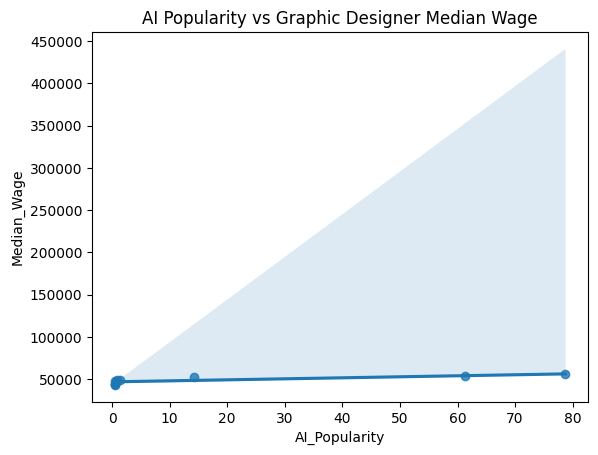

In [ ]:
sns.regplot(data=merged, x="AI_Popularity", y="Employment")
plt.title("AI Popularity vs Graphic Designer Employment")
plt.savefig("plots/ai_vs_graph_empl.jpg")
plt.show()

sns.regplot(data=merged, x="AI_Popularity", y="Median_Wage")
plt.title("AI Popularity vs Graphic Designer Median Wage")
plt.savefig("plots/ai_vs_graph_wage.jpg")
plt.show()


In [77]:
r, p = pearsonr(merged["AI_Popularity"], merged["Employment"])
alpha = 0.05

print(f"Pearson correlation (AI vs Employment): r = {r:.3f}, p = {p:.4f}")

if p < alpha:
    print("Conclusion: There is enough evidence to reject H0. AI popularity is significantly related to employment levels.")
else:
    print("Conclusion: There is not enough evidence to reject H0. We cannot conclude that AI popularity affects employment levels.")


r_w, p_w = pearsonr(merged["AI_Popularity"], merged["Median_Wage"])
alpha = 0.05

print(f"Pearson correlation (AI vs Wage): r = {r_w:.3f}, p = {p_w:.4f}")

if p_w < alpha:

    print("Conclusion: There is enough evidence to reject H0. AI popularity is significantly related to wage levels.")
else:
    print("Conclusion: There is not enough evidence to reject H0. We cannot conclude that AI popularity affects wages.")


Pearson correlation (AI vs Employment): r = 0.334, p = 0.3458
Conclusion: There is not enough evidence to reject H0. We cannot conclude that AI popularity affects employment levels.
Pearson correlation (AI vs Wage): r = 0.812, p = 0.0044
Conclusion: There is enough evidence to reject H0. AI popularity is significantly related to wage levels.


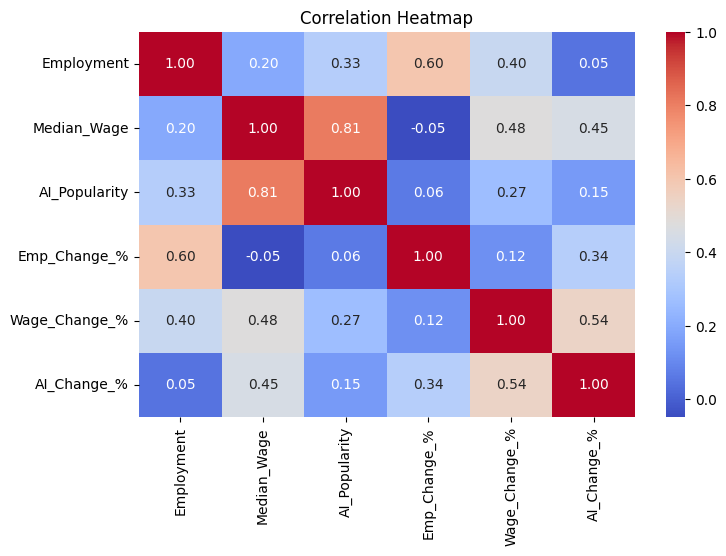

In [78]:
merged["Emp_Change_%"] = merged["Employment"].pct_change() * 100
merged["Wage_Change_%"] = merged["Median_Wage"].pct_change() * 100
merged["AI_Change_%"] = merged["AI_Popularity"].pct_change() * 100

merged
plt.figure(figsize=(8,5))
sns.heatmap(
    merged[["Employment", "Median_Wage", "AI_Popularity",
            "Emp_Change_%", "Wage_Change_%", "AI_Change_%"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Correlation Heatmap")
plt.show()
